In [1]:
import os.path
import sys
sys.path.append("../../")

import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import ThinLens.Elements as Elements
import ThinLens.Maps as Maps
from ThinLens.Models import F0D0Model, SIS18_Cell_minimal, SIS18_Cell, \
    SIS18_Lattice_minimal, SIS18_Lattice


load average model

In [2]:
dim = 6
slices = 4
quadSliceMultiplicity = 2
dtype = torch.double
device = torch.device("cpu")
outputPerElement = False  # exceeds outputAtBPM
outputAtBPM = True

# prepare models
Lattice = SIS18_Lattice

model = Lattice(dim=dim, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,
                dtype=dtype, cellsIdentical=False)

idealModel = Lattice(dim=dim, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity, dtype=dtype,)

# load averaged weights
with open("average.json") as file:
    model.loadJSON(file)

check tunes

In [3]:
import tools.madX

print("model tunes: {}".format(model.getTunes()))

madXTunes = tools.madX.tune(model.madX())
print("tunes from Mad-X: {}".format(madXTunes))

madXTunes = tools.madX.tune(idealModel.madX())
print("ideal model tunes from Mad-X: {}".format(madXTunes))

model tunes: [0.23216562061329332, 0.2994658292786852]
tunes from Mad-X: [4.232165620613289, 3.299465829278689]
ideal model tunes from Mad-X: [4.230762013181338, 3.305631022162825]


estimate beta-beating

In [4]:
twiss, idealTwiss = tools.madX.twissTable(model.madX()), tools.madX.twissTable(idealModel.madX())

beta, idealBeta = twiss["betx"], idealTwiss["betx"]

relDiff = (beta - idealBeta) / idealBeta
maxBetaBeat = np.max(np.abs(relDiff)) * 100  # convert to percent
print("{:.2f}%".format(maxBetaBeat))

3.24%


plot beta functions

Text(0.5, 0, 'pos / m')

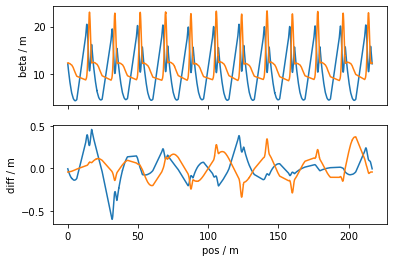

In [5]:
twiss = tools.madX.twissTable(model.madX())
idealTwiss = tools.madX.twissTable(idealModel.madX())

figBeta, axesBeta = plt.subplots(2, sharex=True)
axesBeta[0].plot(twiss.s, twiss["betx"])
axesBeta[0].plot(twiss.s, twiss["bety"])
axesBeta[0].set_ylabel("beta / m")

axesBeta[1].plot(twiss.s, twiss["betx"] - idealTwiss["betx"], )
axesBeta[1].plot(twiss.s, twiss["bety"] - idealTwiss["bety"], )
axesBeta[1].set_ylabel("diff / m")
axesBeta[1].set_xlabel("pos / m")

quantify max deviation from ideal weights

In [6]:
import ThinLens.Elements

# get weights
weights, idealWeights = list(), list()
for e in range(len(model.elements)):
    # only consider quadrupoles
    if not type(model.elements[e]) is ThinLens.Elements.Quadrupole:
        continue
    
    for m in range(len(model.elements[e].maps)):
        if model.elements[e].maps[m].weight.requires_grad:
            weights.append(model.elements[e].maps[m].weight.item())
            idealWeights.append(idealModel.elements[e].maps[m].weight.item())

weights, idealWeights = np.array(weights), np.array(idealWeights)
relWeightDiff = (weights - idealWeights) / idealWeights
maxWeightDeviation = np.max(np.abs(relWeightDiff)) * 100  # convert to percent
print("max. rel. deviation from ideal multipole strengths: {:.2f}%".format(maxWeightDeviation))

max. rel. deviation from ideal multipole strengths: 0.30%
